In [21]:
# import relevant libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score

In [3]:
# load dataframes and relevant csvs

spend_revenue = pd.read_csv(r"/Users/adityamxr/Desktop/finding-marketing-insights/data-analysis/spend_revenue.csv")
sales_full_merged = pd.read_csv(r"/Users/adityamxr/Desktop/finding-marketing-insights/data-analysis/sales_full_merged.csv")
rfm = pd.read_csv(r"/Users/adityamxr/Desktop/finding-marketing-insights/models/rfm.csv")

## K-Means Clustering to Understand RFM profiles + Strategy

In [4]:
# prepare the data (RFM values)
rfm_for_clustering = rfm[['Recency', 'Frequency', 'Monetary']]

In [5]:
# standardize the RFM values (important for K-Means to work effectively)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_for_clustering)

In [6]:
# apply K-Means clustering

# define the number of clusters
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['KMeans_Cluster'] = kmeans.fit_predict(rfm_scaled)

# analyze cluster profiles
# group by the clusters and calculate the mean Recency, Frequency, and Monetary for each cluster
cluster_profiles = rfm.groupby('KMeans_Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'  # Count the number of customers in each cluster
}).rename(columns={'CustomerID': 'Number_of_Customers'}).reset_index()

In [7]:
# display cluster profiles to understand the characteristics
print(cluster_profiles)

# define strategies for each K-Means cluster based on their profiles
# assign strategies to clusters 0, 1, 2, 3
cluster_strategy = {
    0: "High spenders with frequent purchases, engage with personalized offers to retain them.",
    1: "Infrequent purchasers with low spend, use incentives like discounts or loyalty programs.",
    2: "Moderate spenders, encourage repeat purchases with targeted marketing.",
    3: "New or inactive customers, focus on reactivation campaigns with special offers."
}

# map strategies to each K-Means cluster
rfm['Cluster_Strategy'] = rfm['KMeans_Cluster'].map(cluster_strategy)

   KMeans_Cluster     Recency   Frequency      Monetary  Number_of_Customers
0               0   78.437247   12.892038   1950.349249                  741
1               1   81.553672   55.977401   9559.543873                  177
2               2  255.108456   10.194853   1562.488956                  544
3               3   80.833333  270.666667  53059.966194                    6


In [8]:
# display the RFM dataframe with the new clusters and strategies
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment,Strategy,KMeans_Cluster,Cluster_Strategy
0,12346,107,1,171.725887,3,1,1,5,Silver,Provide incentives like discounts or free ship...,0,"High spenders with frequent purchases, engage ..."
1,12347,59,31,10632.890268,3,4,4,11,Premium,Focus on maintaining a strong relationship thr...,1,"Infrequent purchasers with low spend, use ince..."
2,12348,73,8,1341.274742,3,2,2,7,Gold,Engage more with targeted offers and loyalty p...,0,"High spenders with frequent purchases, engage ..."
3,12350,17,11,1080.966849,4,2,2,8,Gold,Engage more with targeted offers and loyalty p...,0,"High spenders with frequent purchases, engage ..."
4,12356,107,13,1648.281319,3,3,3,9,Gold,Engage more with targeted offers and loyalty p...,0,"High spenders with frequent purchases, engage ..."


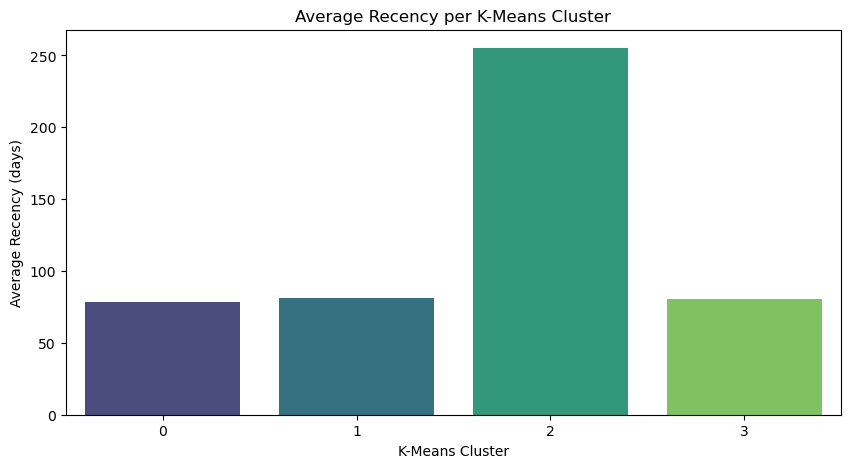

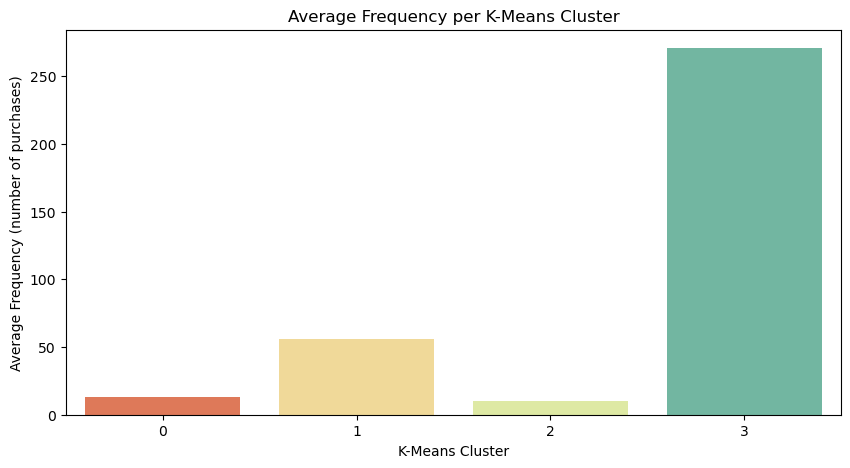

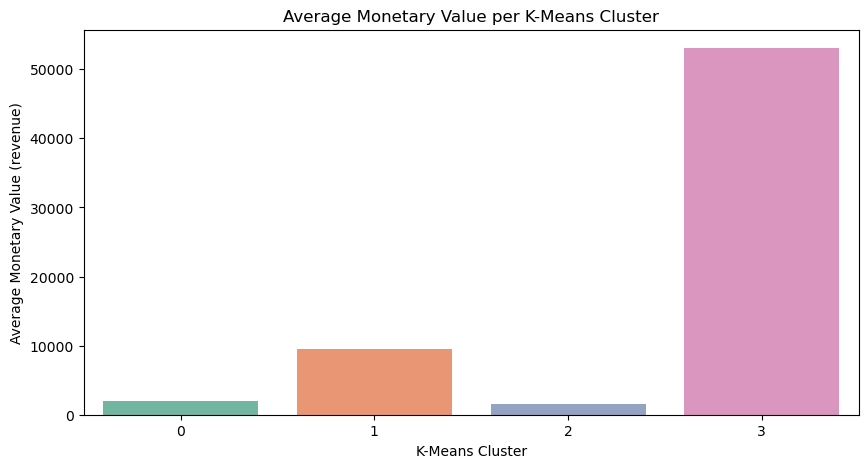

In [12]:
# Visualize the Cluster Profiles

# Calculate the average Recency, Frequency, and Monetary for each cluster
cluster_profiles = rfm.groupby('KMeans_Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

# Bar plot for Recency
plt.figure(figsize=(10, 5))
sns.barplot(x='KMeans_Cluster', y='Recency', data=cluster_profiles, palette='viridis')
plt.title('Average Recency per K-Means Cluster')
plt.xlabel('K-Means Cluster')
plt.ylabel('Average Recency (days)')
plt.show()

# Bar plot for Frequency
plt.figure(figsize=(10, 5))
sns.barplot(x='KMeans_Cluster', y='Frequency', data=cluster_profiles, palette='Spectral')
plt.title('Average Frequency per K-Means Cluster')
plt.xlabel('K-Means Cluster')
plt.ylabel('Average Frequency (number of purchases)')
plt.show()

# Bar plot for Monetary
plt.figure(figsize=(10, 5))
sns.barplot(x='KMeans_Cluster', y='Monetary', data=cluster_profiles, palette='Set2')
plt.title('Average Monetary Value per K-Means Cluster')
plt.xlabel('K-Means Cluster')
plt.ylabel('Average Monetary Value (revenue)')
plt.show()

## Predicting Customer Lifetime Value (Low, Med, High) + Classification Model

In [13]:
# calculate total revenue for each customer by summing their invoice values
customer_revenue = sales_full_merged.groupby('CustomerID')['Invoice_Value'].sum().reset_index()

# rename the column for clarity
customer_revenue.rename(columns={'Invoice_Value': 'Total_Revenue'}, inplace=True)

# merge the customer revenue back into the merged dataset
sales_full_merged = pd.merge(sales_full_merged, customer_revenue, on='CustomerID', how='left')

# check the data
print(sales_full_merged[['CustomerID', 'Total_Revenue']].tail())

       CustomerID  Total_Revenue
52919       14410     828.920096
52920       14410     828.920096
52921       14410     828.920096
52922       14600     534.273276
52923       14600     534.273276


In [14]:
# define CLV dependent variable categories (Low, Medium, High) based on Total_Revenue using quantiles
sales_full_merged['CLV_Category'] = pd.qcut(sales_full_merged['Total_Revenue'], q=3, labels=['Low', 'Medium', 'High'])

# check the distribution of CLV categories
print(sales_full_merged['CLV_Category'].value_counts())

CLV_Category
Medium    17676
Low       17669
High      17579
Name: count, dtype: int64


In [16]:
# transaction_date is in str format - convert to datetime
sales_full_merged['Transaction_Date'] = pd.to_datetime(sales_full_merged['Transaction_Date'])

In [17]:
# recalculate recency and frequency and add them to the sales_full_merged df so they can be used as features for classification

# recalculate Recency
latest_transaction_date = sales_full_merged['Transaction_Date'].max()
sales_full_merged['Recency'] = sales_full_merged.groupby('CustomerID')['Transaction_Date'].transform(lambda x: (latest_transaction_date - x.max()).days)

# recalculate Frequency
sales_full_merged['Frequency'] = sales_full_merged.groupby('CustomerID')['Transaction_ID'].transform('nunique')

# aggregate features like Quantity, Delivery_Charges, Discount_pct at the customer level
customer_features = sales_full_merged.groupby('CustomerID').agg({
    'Recency': 'max',           # most recent transaction date per customer
    'Frequency': 'max',         # total transactions per customer
    'Quantity': 'sum',          # total quantity of products purchased
    'Delivery_Charges': 'mean', # average delivery charges paid by the customer
    'Discount_pct': 'mean',     # average discount percentage received by the customer
}).reset_index()

# merge the features
customer_features = pd.merge(customer_features, sales_full_merged[['CustomerID', 'Total_Revenue', 'CLV_Category']].drop_duplicates(), on='CustomerID')

# check the first few rows
customer_features.head()

,CustomerID,Recency,Frequency,Quantity,Delivery_Charges,Discount_pct,Total_Revenue,CLV_Category
0,12346,107,1,3,75.000000,30.000000,171.725887,Low
1,12347,59,31,342,11.085667,24.666667,10632.890268,High
2,12348,73,8,209,8.571739,24.782609,1341.274742,Low
3,12350,17,11,21,7.522353,30.000000,1080.966849,Low
4,12356,107,13,56,17.708056,30.000000,1648.281319,Low


In [18]:
# prepare the data for classification, excluding Total_Revenue and CLV_Category
X = customer_features[['Recency', 'Frequency', 'Quantity', 'Delivery_Charges', 'Discount_pct']]
y = customer_features['CLV_Category']

# use stratify to ensure each class has approximately the same proportion of samples in both the training and testing sets
# since these sets are randomly assigned
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [19]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# make predictions and evaluate the model
y_pred = clf.predict(X_test)

# evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Generate a classification report and confusion matrix
print('Classification Report:')
print(classification_report(y_test, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9093
Classification Report:
              precision    recall  f1-score   support

        High       0.93      0.72      0.81        36
         Low       0.94      0.97      0.96       314
      Medium       0.78      0.78      0.78        91

    accuracy                           0.91       441
   macro avg       0.88      0.82      0.85       441
weighted avg       0.91      0.91      0.91       441

Confusion Matrix:
[[ 26   0  10]
 [  0 304  10]
 [  2  18  71]]


In [22]:
# perform 5-fold cross-validation on the RandomForest model
cv_scores = cross_val_score(clf, X, y, cv=5)

# print cross-validation scores and mean accuracy
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean Cross-Validation Accuracy: {cv_scores.mean():.4f}')

Cross-Validation Scores: [0.90816327 0.9047619  0.89795918 0.93856655 0.89419795]
Mean Cross-Validation Accuracy: 0.9087


In [23]:
# training accuracy
train_accuracy = clf.score(X_train, y_train)

# test accuracy
test_accuracy = clf.score(X_test, y_test)

print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Training Accuracy: 1.0000
Test Accuracy: 0.9093


### Model is overfitting (> 10% difference between train and test accuracies): implement hyperparameter tuning to limit tree complexity.

In [24]:
# reduce model complexity by limiting tree depth, increasing min_samples_split, etc.
clf_simple = RandomForestClassifier(
    n_estimators=80,        # Reduce the number of trees
    max_depth=8,            # Limit the depth of trees
    min_samples_split=4,     # Increase minimum samples to split nodes
    min_samples_leaf=4,      # Increase the minimum samples per leaf node
    random_state=42
)

# train the simpler model
clf_simple.fit(X_train, y_train)

# evaluate
train_acc_simple = clf_simple.score(X_train, y_train)
test_acc_simple = clf_simple.score(X_test, y_test)

print(f'Simpler Model Training Accuracy: {train_acc_simple:.4f}')
print(f'Simpler Model Test Accuracy: {test_acc_simple:.4f}')

Simpler Model Training Accuracy: 0.9533
Simpler Model Test Accuracy: 0.9138


In [25]:
# reperform 5-fold cross-validation on the simpler model
cv_scores = cross_val_score(clf_simple, X, y, cv=5)

# print cross-validation scores and mean accuracy
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean Cross-Validation Accuracy: {cv_scores.mean():.4f}')

Cross-Validation Scores: [0.92517007 0.89455782 0.9047619  0.91467577 0.89419795]
Mean Cross-Validation Accuracy: 0.9067


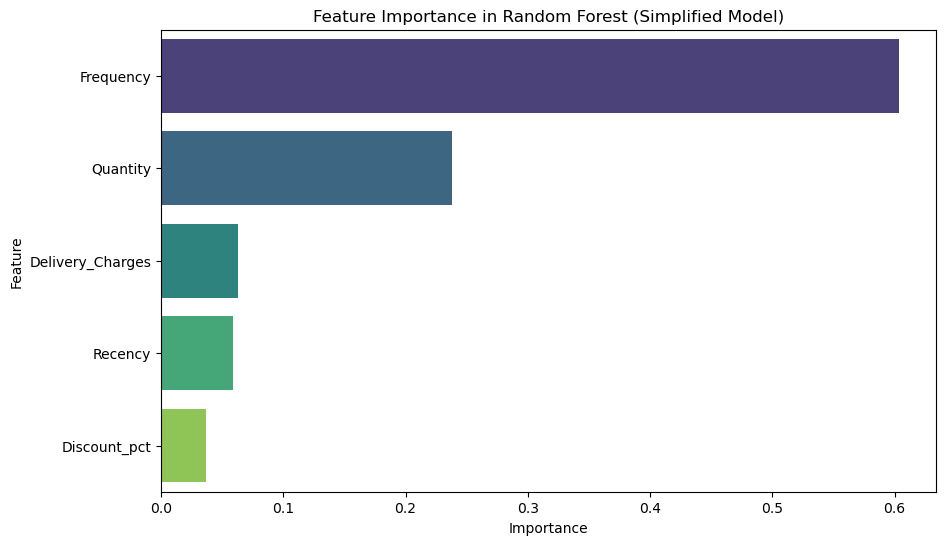

In [26]:
# get feature importance from the trained model
importances = clf_simple.feature_importances_

# create a DataFrame for better visualization
features = X.columns  # X is the feature set you used for training
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

# sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance in Random Forest (Simplified Model)')
plt.show()

**From the feature importance plot, it is clear that the number of transactions a customer makes is the most critical factor in determining whether they fall into Low, Medium, or High CLV categories, with the quantity of products being the second most important feature:**

**1. Frequency's contribution: 60%**

**2. Quantity's contribution: 20%**

**3. Delivery Charges' contribution: 10%**

**4. Recency's contribution: 7%**

**5. Discount_pct's contribution: 3%**

In [27]:
customer_features.to_csv('customer_features.csv', index = False)